In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

%matplotlib notebook

In [3]:
%matplotlib notebook

NOTES:
this code is written after the file: 
'neural_mean_diff_rel_shuffle.ipynb'

To Do: 
compare pairs of movements
implement subsampling to match movement pairs,
save a list of movement pairs that have been matched

once we have neural vector comparisons across pairs of movements, 
compare to behavior psth around that command occurrence.  
play with the number of lags of behavior psth. 




In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


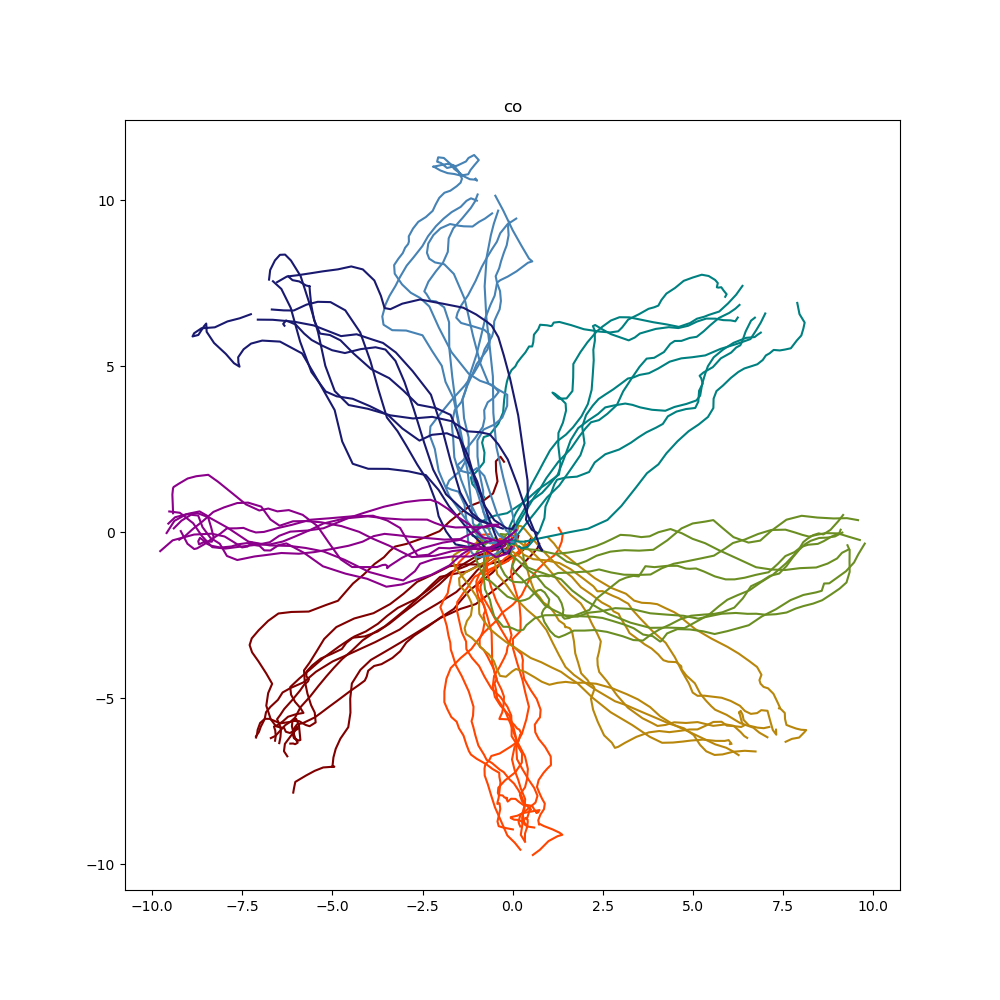

<IPython.core.display.Javascript object>


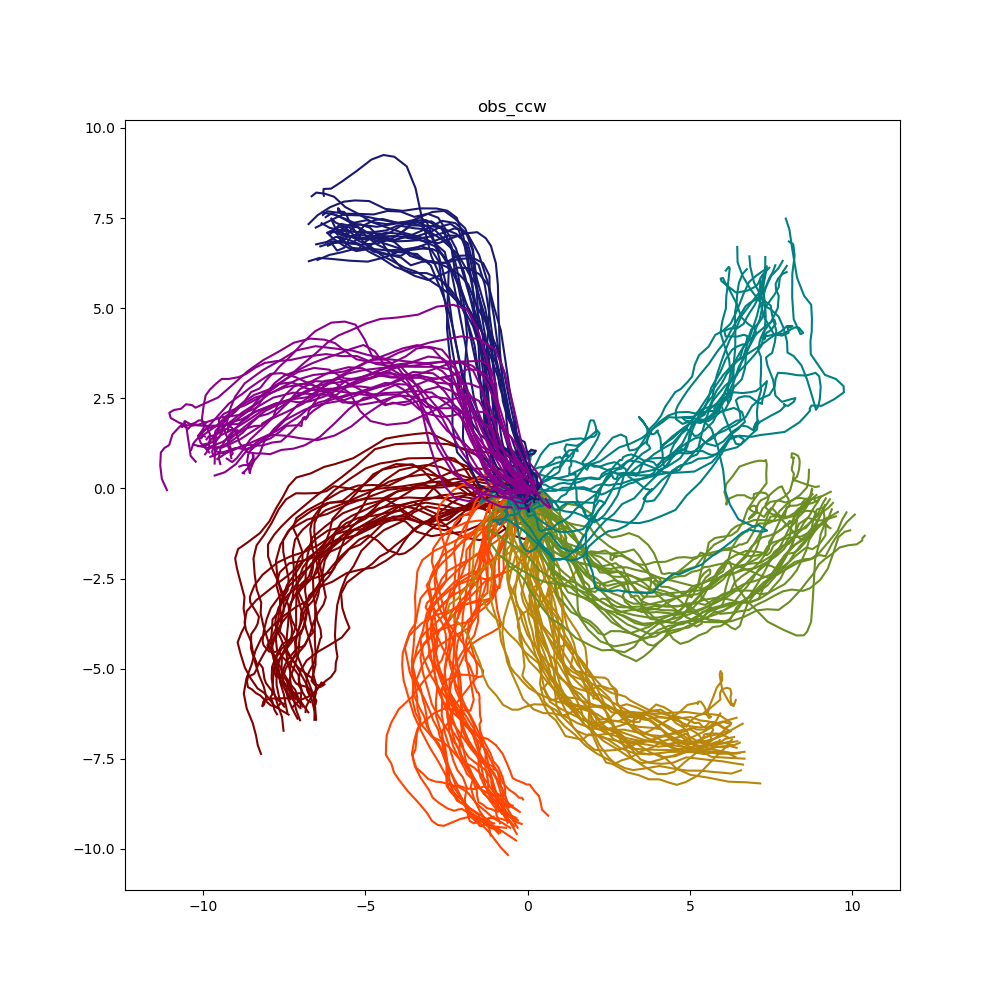

<IPython.core.display.Javascript object>


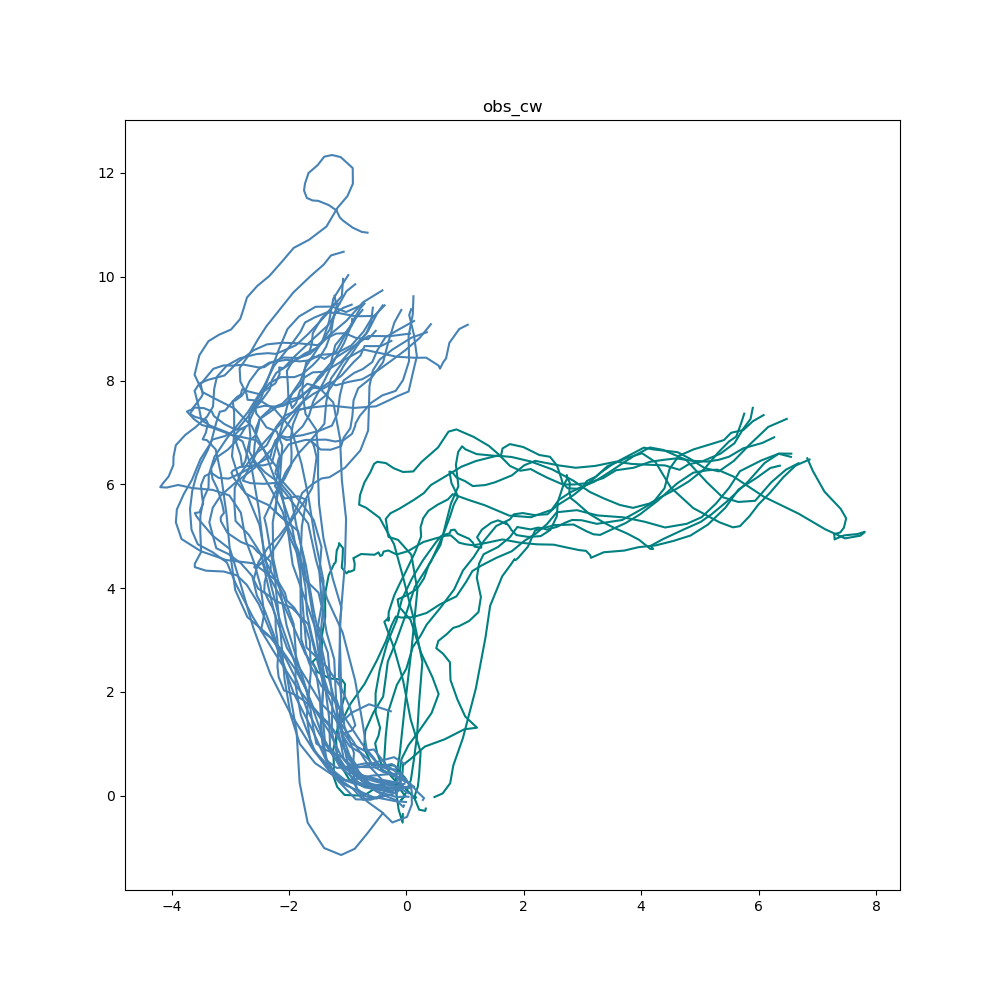

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

<IPython.core.display.Javascript object>


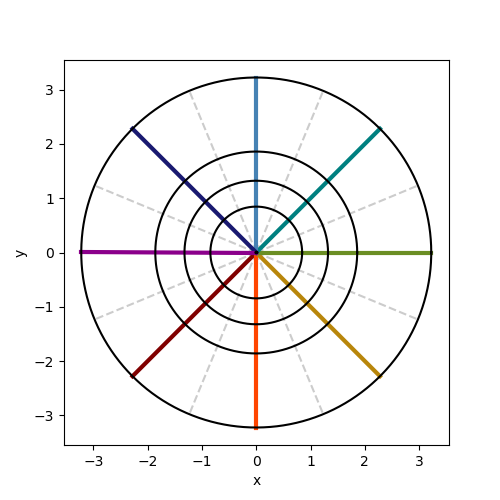

In [7]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### Define movement list.  For each command, identify movements which have enough observations of each command.

In [8]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
        
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [9]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 0 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for c in c_list: 
    bm = c[0]
    ba = c[1]
    
    cm_dic[c] = []
    cm_dic[c,'num_obs'] = []
    #Loop over movement: 
    for m in move_list:
        sel = \
        (df['target']==m[0]) \
        & (df['task_rot']==m[1]) \
        & (df['bin'] >= bin_buffer) \
        & (df['bin_end'] >= bin_buffer) \
        & (df['u_v_mag_bin'] == bm) \
        & (df['u_v_angle_bin'] == ba)
        num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
        #ASSIGN:
        cm_dic[c,m,'sel'] = sel
        cm_dic[c,m,'num_obs'] = num_obs
        if num_obs >= min_obs:
            cm_dic[c].append(m)
            cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for c in c_list:
    bm = c[0]
    ba = c[1]
    cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
    for m in cm_dic[bm,ba]:
        cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
        | cm_dic[c,m,'sel']
#movement-pool sel wil be useful as the global mean for command-activity.

In [10]:
num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

In [11]:
#Make a matrix of command X movement showing which command-movements have more than 15 observations
cm_mat = np.zeros((num_c, num_m))
for c in c_list:
    ci = c2idx[c]
    for m in cm_dic[c]:
        mi = m2idx[m]
        cm_mat[ci,mi]=1

#put it in an da: 
cm_da = xr.DataArray(cm_mat, \
    dims=['c', 'm'])

<IPython.core.display.Javascript object>


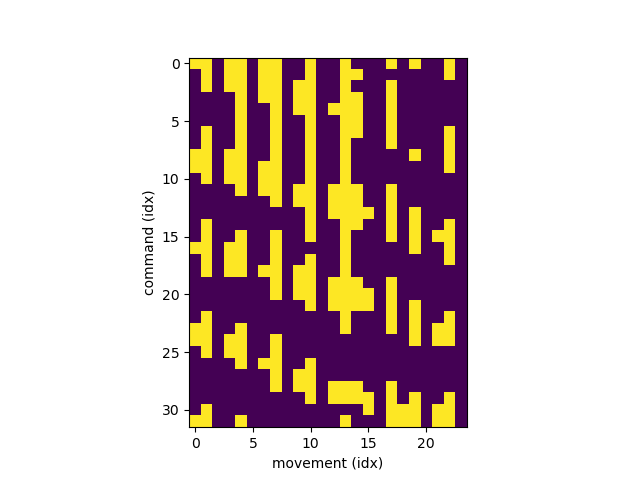

Text(0,0.5,'command (idx)')

In [12]:
plt.figure()
plt.imshow(cm_da)
plt.xlabel('movement (idx)')
plt.ylabel('command (idx)')

In [13]:
#Average number of movements a command appears in
cm_mat.sum(axis=1).mean()

7.4375

In [14]:
#32 commmands, ~5 movements per command, ~10 movement pairs per command, ~320 (command, movement pairs)

In [15]:
#Possible pairs:
cmpair_d = {}
for c in c_list: 
    cmpair_d[c, 'possible_pairs'] = [] #list of pairs
    for i,m1 in enumerate(cm_dic[c]):
        for j,m2 in enumerate(cm_dic[c]):
            pair = (m1,m2)
            if (j>i) and not (m1==m2) and not pair in cmpair_d[c, 'possible_pairs']:
                cmpair_d[c, 'possible_pairs'].append(pair)
        
        

In [18]:
cm_dic[(0,2)]

[(0, 1.1),
 (1, 0),
 (1, 1.1),
 (2, 0),
 (2, 1.1),
 (3, 0),
 (3, 1.1),
 (4, 1.1),
 (5, 1.2)]

In [16]:
cmpair_d[(2,0),'possible_pairs']

[((0, 0), (0, 1.1)),
 ((0, 0), (1, 0)),
 ((0, 0), (1, 1.1)),
 ((0, 0), (2, 1.1)),
 ((0, 0), (4, 1.1)),
 ((0, 0), (6, 1.1)),
 ((0, 0), (7, 1.1)),
 ((0, 1.1), (1, 0)),
 ((0, 1.1), (1, 1.1)),
 ((0, 1.1), (2, 1.1)),
 ((0, 1.1), (4, 1.1)),
 ((0, 1.1), (6, 1.1)),
 ((0, 1.1), (7, 1.1)),
 ((1, 0), (1, 1.1)),
 ((1, 0), (2, 1.1)),
 ((1, 0), (4, 1.1)),
 ((1, 0), (6, 1.1)),
 ((1, 0), (7, 1.1)),
 ((1, 1.1), (2, 1.1)),
 ((1, 1.1), (4, 1.1)),
 ((1, 1.1), (6, 1.1)),
 ((1, 1.1), (7, 1.1)),
 ((2, 1.1), (4, 1.1)),
 ((2, 1.1), (6, 1.1)),
 ((2, 1.1), (7, 1.1)),
 ((4, 1.1), (6, 1.1)),
 ((4, 1.1), (7, 1.1)),
 ((6, 1.1), (7, 1.1))]

In [60]:
### Match pairs
#For each c, have a pair of movements to compare
#loop command, m_pair, try to match them, if i can match them, then save in 'matched_pairs'
#save the observations to keep of each movement to ensure the pairs are matched.
t_start = timeit.default_timer()

match_var = ['u_vx', 'u_vy']
num_matched = 0
num_not_matched = 0

for c in c_list:
    cmpair_d[c,'matched_pairs'] = []
    cmpair_d[c,'not_matched_pairs'] = []
    
    for mp in cmpair_d[c,'possible_pairs']:
        m0=mp[0]
        m1=mp[1]

        #-------------------------------------------------------
        d_list = []
        d0=df.loc[cm_dic[c,m0,'sel'], match_var]
        d0_da = xr.DataArray(np.array(d0).T,
                    coords={'v':list(d0.columns),
                            'observation': d0.index.values},
                    dims=['v','observation'])

        d1=df.loc[cm_dic[c,m1,'sel'], match_var]
        d1_da = xr.DataArray(np.array(d1).T,
                    coords={'v':list(d1.columns),
                            'observation': d1.index.values},
                    dims=['v','observation'])

        d_list.append(d0_da)
        d_list.append(d1_da)

        #-------------------------------------------------------
        success, kept_list, discard_list, df_match, ttest_r, mean_r  = \
        bmi_b.subsample_2datasets_to_match_mean_v2(match_var, d_list, p_sig=0.05, max_iter=1000)
        
        cmpair_d[c,m0,m1,'match_success'] = success
        cmpair_d[c,m0,m1,'kept_list'] = kept_list
        cmpair_d[c,m0,m1,'discard_list'] = discard_list
        cmpair_d[c,m0,m1,'df_match'] = df_match
        cmpair_d[c,m0,m1,'ttest_r'] = ttest_r
        cmpair_d[c,m0,m1,'mean_r'] = mean_r
        
        if success:
            cmpair_d[c,'matched_pairs'].append(mp)
            num_matched += 1
        else:
            cmpair_d[c,'not_matched_pairs'].append(mp)
            num_not_matched += 1
            
t_elapsed = timeit.default_timer()-t_start
print('time elapsed: ', t_elapsed)

matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
m

In [61]:

cmpair_d[c, 'matched_pairs']

[((0, 0), (0, 1.1)),
 ((0, 0), (1, 1.1)),
 ((0, 0), (4, 1.1)),
 ((0, 0), (5, 1.2)),
 ((0, 0), (6, 0)),
 ((0, 0), (6, 1.1)),
 ((0, 0), (7, 0)),
 ((0, 0), (7, 1.1)),
 ((0, 1.1), (1, 1.1)),
 ((0, 1.1), (4, 1.1)),
 ((0, 1.1), (5, 1.2)),
 ((0, 1.1), (6, 0)),
 ((0, 1.1), (6, 1.1)),
 ((0, 1.1), (7, 0)),
 ((0, 1.1), (7, 1.1)),
 ((1, 1.1), (4, 1.1)),
 ((1, 1.1), (5, 1.2)),
 ((1, 1.1), (6, 0)),
 ((1, 1.1), (6, 1.1)),
 ((1, 1.1), (7, 0)),
 ((1, 1.1), (7, 1.1)),
 ((4, 1.1), (5, 1.2)),
 ((4, 1.1), (6, 0)),
 ((4, 1.1), (6, 1.1)),
 ((4, 1.1), (7, 0)),
 ((4, 1.1), (7, 1.1)),
 ((5, 1.2), (6, 0)),
 ((5, 1.2), (6, 1.1)),
 ((5, 1.2), (7, 0)),
 ((5, 1.2), (7, 1.1)),
 ((6, 0), (6, 1.1)),
 ((6, 0), (7, 0)),
 ((6, 0), (7, 1.1)),
 ((6, 1.1), (7, 0)),
 ((6, 1.1), (7, 1.1)),
 ((7, 0), (7, 1.1))]

In [62]:
#Calculate:
#global_mean: 
bmi_sample_period = 0.1
min_fr = 0.5*bmi_sample_period
for c in c_list:
    nc_mat = df.loc[cm_dic[c,'sel'], n_list]
    n_c = nc_mat.mean(axis=0)
    cm_dic[c, 'n_mean'] = n_c  
    cm_dic[c, 'n_valid'] = np.where(n_c>=min_fr)[0]
    cm_dic[c, 'n_label_valid'] = ['n_' + str(i) for i in cm_dic[c, 'n_valid']]
    cm_dic[c, 'num_n_valid'] = len(cm_dic[c, 'n_valid'])
    cm_dic[c, 'n_mean_valid'] = n_c.loc[cm_dic[c, 'n_label_valid']]
    



In [63]:
#Calculate the mean and sigma of each neuron, pooling all data: 
#np.cov: row: var, col: obs
n_cov = np.cov(df.loc[:,n_list].T)
n_var = np.diag(n_cov)
n_std = n_var**(0.5)
n_mean = df.loc[:,n_list].mean()

# plt.figure(figsize=(6,6))
# plt.scatter(n_mean, n_std)
# plt.xlabel('mean')
# plt.ylabel('std')

In [54]:
df.shape

(11971, 87)

In [ ]:
n_mean

In [21]:
r

<xarray.DataArray (v: 44)>
array([1.324786, 0.487179, 0.008547, 0.025641, 1.735043, 2.905983, 1.589744,
       0.435897, 0.025641, 0.      , 0.      , 1.837607, 0.042735, 0.017094,
       1.290598, 2.094017, 0.717949, 0.880342, 1.384615, 0.709402, 0.461538,
       1.589744, 1.726496, 1.752137, 0.547009, 0.623932, 1.581197, 2.247863,
       1.      , 0.632479, 1.487179, 1.74359 , 2.495726, 1.179487, 0.65812 ,
       1.700855, 2.119658, 1.666667, 2.606838, 2.222222, 0.076923, 8.034188,
       0.410256, 0.91453 ])
Coordinates:
  * v        (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [22]:
r_z

<xarray.DataArray (v: 44)>
array([ 0.08182 ,  0.025825, -0.084477, -0.034211,  0.472145,  0.436347,
        0.198027,  0.353874,  0.067636, -0.103532, -0.071565, -0.133925,
       -0.027734, -0.03721 ,  0.339417,  0.25612 ,  0.151569,  0.303793,
        0.048835,  0.167152, -0.054856,  0.205818,  0.307396,  0.116646,
        0.338603,  0.087694,  0.361276,  0.616689,  0.08378 , -0.114699,
        0.223659, -0.152972,  0.926799,  0.586987,  0.453056,  0.795452,
       -0.342174, -0.324071, -0.44248 ,  1.010223, -1.061606,  1.622701,
       -0.224746, -0.299905])
Coordinates:
  * v        (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [23]:
n_mean

n_0     1.225506
n_1     0.469561
n_2     0.020859
n_3     0.031730
n_4     1.191127
n_5     2.235018
n_6     1.355823
n_7     0.256489
n_8     0.016918
n_9     0.010871
n_10    0.005096
n_11    2.025547
n_12    0.048852
n_13    0.022761
n_14    0.943606
n_15    1.751529
n_16    0.599878
n_17    0.633034
n_18    1.328645
n_19    0.580785
n_20    0.500272
n_21    1.351338
n_22    1.354872
n_23    1.603615
n_24    0.344544
n_25    0.558364
n_26    1.181954
n_27    1.457671
n_28    0.919826
n_29    0.729447
n_30    1.239299
n_31    1.975608
n_32    1.313833
n_33    0.675160
n_34    0.368392
n_35    0.886194
n_36    2.913711
n_37    2.311591
n_38    3.896997
n_39    1.040291
n_40    1.658445
n_41    2.624609
n_42    0.701794
n_43    1.340196
dtype: float64

In [64]:
#USE MATCHED DATA
b_bin_buffer = 5
sel_b = (df['bin']>=b_bin_buffer)&(df['bin_end']>=b_bin_buffer)

t_start = timeit.default_timer()
for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
        cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
            
        #--------------------------------------------------------------------------------
        #n_mean: 
        n_mean_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da = bmi_b.df_idx2da(df, idx, n_list)
            da = da/bmi_sample_period
            r = da.mean(dim='observation')
            n_mean_list.append(r)

        cmpair_d[c,mp[0],mp[1],'n_mean'] = n_mean_list
        cmpair_d[c,mp[0],mp[1],'n_diff_L2'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1], ord=2)
        cmpair_d[c,mp[0],mp[1],'n_diff_L2_avg'] = cmpair_d[c,mp[0],mp[1],'n_diff_L2']/num_neurons
        cmpair_d[c,mp[0],mp[1],'n_diff_L1_avg'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1], ord=1)/num_neurons
        #On valid neurons with > min_fr:
        n_label_valid = cm_dic[c, 'n_label_valid']
        num_n_valid = cm_dic[c, 'num_n_valid']
        n_c_mean_valid = cm_dic[c, 'n_mean_valid']/bmi_sample_period
        
        n0 =  n_mean_list[0].loc[n_label_valid]
        n1 =  n_mean_list[1].loc[n_label_valid]
        diff_valid = n0-n1
        frac_diff_valid = diff_valid/n_c_mean_valid
        cmpair_d[c,mp[0],mp[1],'n_diff_L1_valid'] = np.linalg.norm(diff_valid)/num_n_valid
        cmpair_d[c,mp[0],mp[1],'n_frac_diff_L1_valid'] = np.linalg.norm(frac_diff_valid)/num_n_valid
        
        #--------------------------------------------------------------------------------
        #zscore: 
        n_mean_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da = bmi_b.df_idx2da(df, idx, n_list)
            r = da.mean(dim='observation')            
            r_z = (r-n_mean)/n_std
            n_mean_list.append(r_z)
                
        cmpair_d[c,mp[0],mp[1],'z_n_mean'] = n_mean_list
        cmpair_d[c,mp[0],mp[1],'z_n_diff_L2'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1])
        cmpair_d[c,mp[0],mp[1],'z_n_diff_L1_avg'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1], ord=1)/num_neurons
        #On valid neurons with > min_fr:
        n_label_valid = cm_dic[c, 'n_label_valid']
        num_n_valid = cm_dic[c, 'num_n_valid']
        n_c_mean_valid = cm_dic[c, 'n_mean_valid']
        n_c_mean_valid = (n_c_mean_valid-n_mean.loc[n_label_valid])/n_std[cm_dic[c, 'n_valid']]
        
        n0 =  n_mean_list[0].loc[n_label_valid]
        n1 =  n_mean_list[1].loc[n_label_valid]
        diff_valid = n0-n1
        frac_diff_valid = diff_valid/n_c_mean_valid
        
        cmpair_d[c,mp[0],mp[1],'z_n_diff_L1_valid'] = np.linalg.norm(diff_valid)/num_n_valid
        cmpair_d[c,mp[0],mp[1],'z_n_frac_diff_L1_valid'] = np.linalg.norm(frac_diff_valid)/num_n_valid        
        

        #--------------------------------------------------------------------------------
        #u_psth:
        win = [-5,5]
        psth_var = ['u_vx', 'u_vy']
        psth_list = []
        psth_sem_list = []
        b_psth_num_obs = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            
            #compute the idxs that work for calculating the behavior PSTH:
            idx_sel = pd.Series(False,index=df.index)
            idx_sel.loc[idx] = True
            idx_sel_a = idx_sel & sel_b
            idx_a = np.where(idx_sel_a)[0]
            
            da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx_a, win, psth_var)
            psth_list.append(psth)
            psth_sem_list.append(psth_sem)
            b_psth_num_obs.append(len(idx_a))            

        #ASSIGN:
        cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
        cmpair_d[c,mp[0],mp[1],'u_psth'] = psth_list
        cmpair_d[c,mp[0],mp[1],'u_diff'] = np.linalg.norm(psth_list[0]-psth_list[1])
        cmpair_d[c,mp[0],mp[1],'u_psth_sem'] = psth_sem_list
        cmpair_d[c,mp[0],mp[1],'u_psth_num_obs'] = b_psth_num_obs
        
        

t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

(0, 0)
((0, 0), (0, 1.1))
((0, 0), (1, 0))
((0, 0), (1, 1.1))
((0, 0), (2, 0))
((0, 0), (2, 1.1))
((0, 0), (3, 1.1))
((0, 0), (4, 1.1))
((0, 0), (5, 1.2))
((0, 0), (6, 1.1))
((0, 0), (7, 1.1))
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((0, 1.1), (5, 1.2))
((0, 1.1), (6, 1.1))
((0, 1.1), (7, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 0), (5, 1.2))
((1, 0), (6, 1.1))
((1, 0), (7, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((1, 1.1), (5, 1.2))
((1, 1.1), (6, 1.1))
((1, 1.1), (7, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 0), (5, 1.2))
((2, 0), (6, 1.1))
((2, 0), (7, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (5, 1.2))
((2, 1.1), (6, 1.1))
((2, 1.1), (7, 1.1))
((3, 1.1), (4, 1.1))
((3, 1.1), (5, 1.2))
((3, 1.1), (6, 1.1))
((3, 1.1), (7, 1.1))
((4, 1.1), (5, 1.2))
((4

((4, 0), (4, 1.2))
((4, 0), (5, 0))
((4, 0), (5, 1.2))
((4, 0), (6, 1.1))
((4, 1.1), (4, 1.2))
((4, 1.1), (5, 0))
((4, 1.1), (5, 1.2))
((4, 1.1), (6, 1.1))
((4, 1.2), (5, 0))
((4, 1.2), (5, 1.2))
((4, 1.2), (6, 1.1))
((5, 0), (5, 1.2))
((5, 0), (6, 1.1))
((5, 1.2), (6, 1.1))
(1, 6)
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((0, 1.1), (4, 1.2))
((0, 1.1), (5, 1.2))
((0, 1.1), (6, 1.1))
((0, 1.1), (7, 1.1))
((3, 1.1), (4, 1.1))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((3, 1.1), (6, 1.1))
((3, 1.1), (7, 1.1))
((4, 1.1), (4, 1.2))
((4, 1.1), (5, 1.2))
((4, 1.1), (6, 1.1))
((4, 1.1), (7, 1.1))
((4, 1.2), (5, 1.2))
((4, 1.2), (6, 1.1))
((4, 1.2), (7, 1.1))
((5, 1.2), (6, 1.1))
((5, 1.2), (7, 1.1))
((6, 1.1), (7, 1.1))
(1, 7)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((0, 1.1), (5, 1.2))
((0, 1.1), (6, 1.1))
((0, 1.1), (7, 0))
((0, 1.1), (7, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((1, 1.1), (5, 1.2))
((1, 1.1), (6, 1.1)

### Inspect

In [24]:
c

(3, 7)

In [174]:
m0 = mp[0]
m0

(7, 0)

In [175]:
m1 = mp[1]
m1

(7, 1.1)

In [176]:
cmpair_d[c,m0,m1,'n_diff']

2.0783822386484014

In [177]:
cmpair_d[c,m0,m1,'u_diff']

1.9522656252544996

<IPython.core.display.Javascript object>


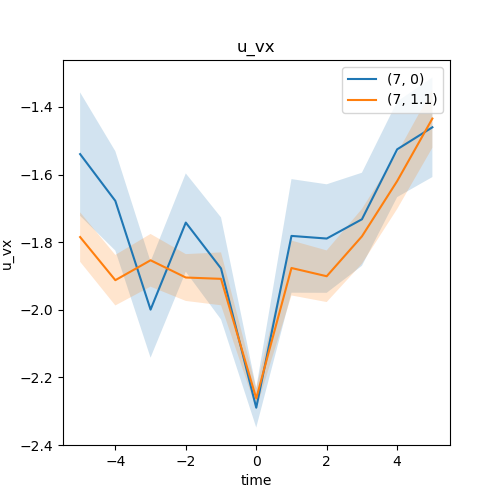

<IPython.core.display.Javascript object>


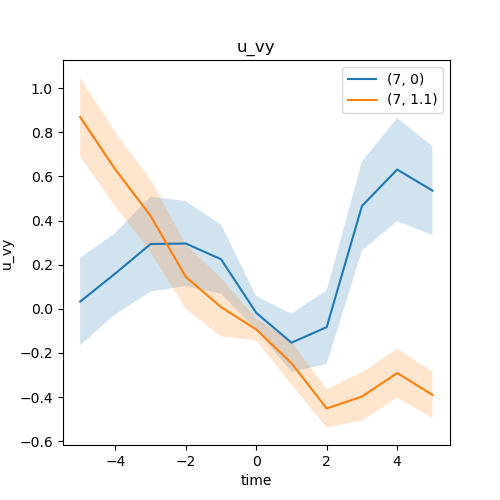

In [19]:
#Plot the psth: 


alpha = 0.2
t = np.arange(win[0],win[1]+1)
for var in psth_var:
    plt.figure(figsize=(5,5))
    
    for i in range(2):
        y = cmpair_d[c,m0,m1,'u_psth'][i].loc[var, :]
        y_sem = cmpair_d[c,m0,m1,'u_psth_sem'][i].loc[var, :]
        plt.plot(t,y,label=mp[i])
        plt.fill_between(t,y-y_sem,y+y_sem,alpha=alpha)

    plt.title(var)
    plt.xlabel('time')
    plt.ylabel(var)
    plt.legend()


In [ ]:
#With subsampling up to 20: 

In [179]:
num_matched

393

In [180]:
num_not_matched

32

In [ ]:
### Without subsampling:

In [21]:
num_matched

315

In [22]:
num_not_matched

110

In [93]:
num_matched

762

In [94]:
num_not_matched

88

### Make a results df

In [47]:
# df_nu_z = copy.deepcopy(df_nu)

In [65]:
#USING ONLY MATCHED DATA:
t_start = timeit.default_timer()

# TODO: 
u_win = [-5,5] 
u_win_t = np.arange(u_win[0], u_win[1]+1)
# u_win_t = 0
df_list = []
df_columns = ['n_diff_L2', 'n_diff_L1_avg', 'n_diff_L1_valid', 'n_frac_diff_L1_valid'\
              'z_n_diff_L2', 'z_n_diff_L1_avg', 'z_n_diff_L1_valid', 'z_n_frac_diff_L1_valid'\
              'u_diff',\
              'obs_0', 'obs_1','b_obs_0','b_obs_1'\
              'command_idx', 'movement_idx_0', 'movement_idx_1',\
              'u_v_mag_bin','u_v_angle_bin',\
              'target', 'task_rot']

for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
            
        df_i = pd.DataFrame(np.zeros(len(df_columns)).reshape(1,-1), columns=df_columns)

        df_i.loc[0,'n_diff_L2'] = cmpair_d[c,mp[0],mp[1],'n_diff_L2']
        df_i.loc[0,'n_diff_L1_avg'] = cmpair_d[c,mp[0],mp[1],'n_diff_L1_avg']
        df_i.loc[0,'n_diff_L1_valid'] = cmpair_d[c,mp[0],mp[1],'n_diff_L1_valid']
        df_i.loc[0,'n_frac_diff_L1_valid'] = cmpair_d[c,mp[0],mp[1],'n_frac_diff_L1_valid']
        
        df_i.loc[0,'z_n_diff_L2'] = cmpair_d[c,mp[0],mp[1],'z_n_diff_L2']
        df_i.loc[0,'z_n_diff_L1_avg'] = cmpair_d[c,mp[0],mp[1],'z_n_diff_L1_avg']
        df_i.loc[0,'z_n_diff_L1_valid'] = cmpair_d[c,mp[0],mp[1],'z_n_diff_L1_valid']
        df_i.loc[0,'z_n_frac_diff_L1_valid'] = cmpair_d[c,mp[0],mp[1],'z_n_frac_diff_L1_valid']        
        
        u0 = cmpair_d[c,mp[0],mp[1],'u_psth'][0].loc[:,u_win_t]
        u1 = cmpair_d[c,mp[0],mp[1],'u_psth'][1].loc[:,u_win_t]

        df_i.loc[0,'u_diff'] = \
            np.linalg.norm(u0-u1)

        df_i.loc[0,'obs_0'] = obs0
        df_i.loc[0,'obs_1'] = obs1
        
        
        df_i.loc[0,'b_obs_0'] = cmpair_d[c,mp[0],mp[1],'u_psth_num_obs'][0]
        df_i.loc[0,'b_obs_1'] = cmpair_d[c,mp[0],mp[1],'u_psth_num_obs'][1]

        df_i.loc[0,'command_idx'] = c2idx[c]
        df_i.loc[0,'movement_idx_0'] = m2idx[mp[0]]
        df_i.loc[0,'movement_idx_1'] = m2idx[mp[1]]
        
        df_i.loc[0,'task_0'] = mp[0][1]
        df_i.loc[0,'task_1'] = mp[1][1]
        
        df_i.loc[0,'target_0'] = mp[0][0]
        df_i.loc[0,'target_1'] = mp[1][0]        

        df_i.loc[0,'u_v_mag_bin'] = c[0]
        df_i.loc[0,'u_v_angle_bin'] = c[1]

        df_list.append(df_i)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
df_nu = pd.concat(df_list,ignore_index=True)

(0, 0)
((0, 0), (0, 1.1))
((0, 0), (1, 0))
((0, 0), (1, 1.1))
((0, 0), (2, 0))
((0, 0), (2, 1.1))
((0, 0), (3, 1.1))
((0, 0), (4, 1.1))
((0, 0), (5, 1.2))
((0, 0), (6, 1.1))
((0, 0), (7, 1.1))
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((0, 1.1), (5, 1.2))
((0, 1.1), (6, 1.1))
((0, 1.1), (7, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 0), (5, 1.2))
((1, 0), (6, 1.1))
((1, 0), (7, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((1, 1.1), (5, 1.2))
((1, 1.1), (6, 1.1))
((1, 1.1), (7, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 0), (5, 1.2))
((2, 0), (6, 1.1))
((2, 0), (7, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (5, 1.2))
((2, 1.1), (6, 1.1))
((2, 1.1), (7, 1.1))
((3, 1.1), (4, 1.1))
((3, 1.1), (5, 1.2))
((3, 1.1), (6, 1.1))
((3, 1.1), (7, 1.1))
((4, 1.1), (5, 1.2))
((4

((4, 1.2), (5, 0))
((4, 1.2), (5, 1.2))
((4, 1.2), (6, 1.1))
((5, 0), (5, 1.2))
((5, 0), (6, 1.1))
((5, 1.2), (6, 1.1))
(1, 6)
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((0, 1.1), (4, 1.2))
((0, 1.1), (5, 1.2))
((0, 1.1), (6, 1.1))
((0, 1.1), (7, 1.1))
((3, 1.1), (4, 1.1))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((3, 1.1), (6, 1.1))
((3, 1.1), (7, 1.1))
((4, 1.1), (4, 1.2))
((4, 1.1), (5, 1.2))
((4, 1.1), (6, 1.1))
((4, 1.1), (7, 1.1))
((4, 1.2), (5, 1.2))
((4, 1.2), (6, 1.1))
((4, 1.2), (7, 1.1))
((5, 1.2), (6, 1.1))
((5, 1.2), (7, 1.1))
((6, 1.1), (7, 1.1))
(1, 7)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((0, 1.1), (5, 1.2))
((0, 1.1), (6, 1.1))
((0, 1.1), (7, 0))
((0, 1.1), (7, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((1, 1.1), (5, 1.2))
((1, 1.1), (6, 1.1))
((1, 1.1), (7, 0))
((1, 1.1), (7, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (5, 1.2))
((2, 1.1), (6, 1.1))
((2, 1.1), (7, 0))
((2, 1.1), 

### Plot results

In [32]:
u.shape

(751L,)

In [33]:
n.shape

(751L,)

<IPython.core.display.Javascript object>


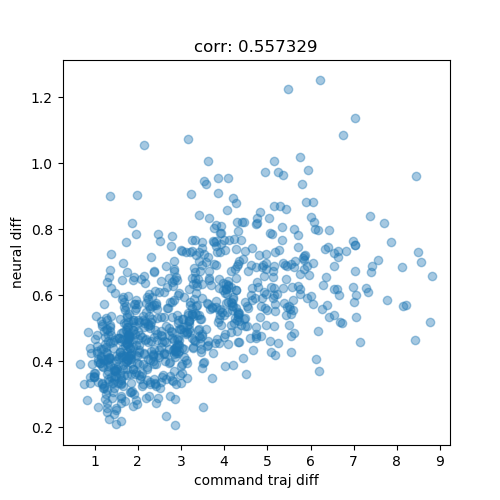

Text(0,0.5,'neural diff')

In [66]:
n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)

b_min_obs=15
sel_b = (df_nu.loc[:,'b_obs_0']>=b_min_obs) & (df_nu.loc[:,'b_obs_1']>=b_min_obs)

sel = sel_n #&sel_b

u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff_L2']/num_neurons # 
# n = df_nu.loc[sel,'z_n_diff_L1_avg'] 
# n = df_nu.loc[sel,'n_diff_L1_valid'] 
# n = df_nu.loc[sel,'n_frac_diff_L1_valid'] 

nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n,alpha=0.4)
plt.title('corr: ' + str(round(nu_corr,6)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0,7])


In [67]:
n.shape

(789L,)

In [59]:
n.shape

(751L,)

<IPython.core.display.Javascript object>


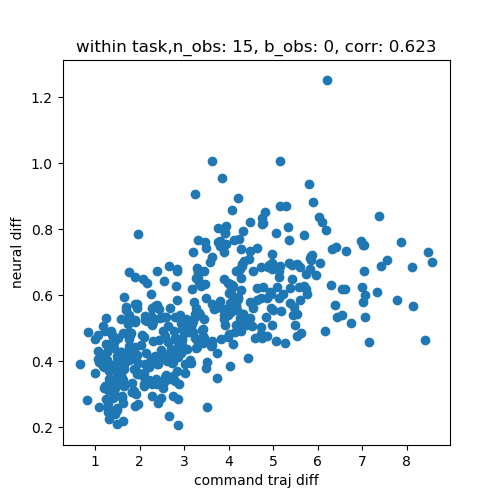

Text(0,0.5,'neural diff')

In [56]:
#ACROSS or WITHIN TASK: 
across_task = False
within_task = True

n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)

b_min_obs=0
sel_b = (df_nu.loc[:,'b_obs_0']>=b_min_obs) & (df_nu.loc[:,'b_obs_1']>=b_min_obs)

sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

if across_task:
    sel = sel_n & sel_b & sel_across_task
    title_str = 'across task'
elif within_task:
    sel = sel_n & sel_b & sel_within_task
    title_str = 'within task'
else:
    sel = sel_n & sel_b    
    title_str = 'both tasks'
    
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff_L2']/num_neurons
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(title_str + ',n_obs: ' + str(n_min_obs) + ', b_obs: '+ str(b_min_obs) + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')

### Pick an example command


In [ ]:
#good examples: 
#(1,0), (1,1), (1,2),  r=0.7
#(0,2) r=0.857
#(0,5) r=0.803

#bad commands: angle 3


In [50]:
list(df_nu.columns)

['n_diff_L2',
 'n_diff_L1_avg',
 'n_diff_L1_valid',
 'n_frac_diff_L1_validz_n_diff_L2',
 'z_n_diff_L1_avg',
 'z_n_diff_L1_valid',
 'z_n_frac_diff_L1_validu_diff',
 'obs_0',
 'obs_1',
 'b_obs_0',
 'b_obs_1command_idx',
 'movement_idx_0',
 'movement_idx_1',
 'u_v_mag_bin',
 'u_v_angle_bin',
 'target',
 'task_rot',
 'n_frac_diff_L1_valid',
 'z_n_diff_L2',
 'z_n_frac_diff_L1_valid',
 'u_diff',
 'b_obs_1',
 'command_idx',
 'task_0',
 'task_1',
 'target_0',
 'target_1']

In [55]:
m

(5, 1.2)

In [95]:
m_analyze

[(0, 1.1),
 (1, 0),
 (1, 1.1),
 (2, 0),
 (2, 1.1),
 (3, 0),
 (3, 1.1),
 (4, 1.1),
 (5, 1.2)]

In [97]:
list(df_nu.columns)

['n_diff_L2',
 'n_diff_L1_avg',
 'n_diff_L1_valid',
 'n_frac_diff_L1_validz_n_diff_L2',
 'z_n_diff_L1_avg',
 'z_n_diff_L1_valid',
 'z_n_frac_diff_L1_validu_diff',
 'obs_0',
 'obs_1',
 'b_obs_0',
 'b_obs_1command_idx',
 'movement_idx_0',
 'movement_idx_1',
 'u_v_mag_bin',
 'u_v_angle_bin',
 'target',
 'task_rot',
 'n_frac_diff_L1_valid',
 'z_n_diff_L2',
 'z_n_frac_diff_L1_valid',
 'u_diff',
 'b_obs_1',
 'command_idx',
 'task_0',
 'task_1',
 'target_0',
 'target_1']

In [105]:
df_nu.iloc[0,:].loc['n_diff_L2']

16.508363615186997

### Find the best example movement pairs

In [139]:
#Loop through each movement, find its min and max values when compared to other movements
df_list = []

sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])
sel_command = (sel_angle)&(sel_mag)

df_columns = ['u_min', 'u_max', 'n_min', 'n_max', 'target_0', 'task_0', 'target_min', 'task_min', 'target_max', 'task_max']
for m in m_analyze:
    df_i = pd.DataFrame(np.zeros(len(df_columns)).reshape(1,-1), columns=df_columns)
    df_i['target_0'] = m[0]
    df_i['task_0'] = m[1]
    
    #Loop over all comparions in the df:
    
    #Select comparisons that include the movement: 
    sel_m = \
        ((df_nu['target_0'] == m[0])&(df_nu['task_0'] == m[1]))\
        |((df_nu['target_1'] == m[0])&(df_nu['task_1'] == m[1]))
    sel = sel_m & sel_command
    df_sel = df_nu.loc[sel,:]
    
    #MIN:
    i_min = np.array(df_nu.loc[sel,'u_diff']).argmin()
#     i_min = np.array(df_nu.loc[sel,'n_diff_L2']).argmin()
    
    df_i['u_min'] = df_sel.iloc[i_min,:].loc['u_diff']
    df_i['n_min'] = df_sel.iloc[i_min,:].loc['n_diff_L2']
    
    if (df_sel.iloc[i_min,:].loc['target_0'] == m[0]) & (df_sel.iloc[i_min,:].loc['task_0'] == m[1]):
        df_i['target_min'] = df_sel.iloc[i_min,:].loc['target_1']
        df_i['task_min'] = df_sel.iloc[i_min,:].loc['task_1']
    else:         
        df_i['target_min'] = df_sel.iloc[i_min,:].loc['target_0']
        df_i['task_min'] = df_sel.iloc[i_min,:].loc['task_0']
        
    
    #MAX: 
    i_max = np.array(df_nu.loc[sel,'u_diff']).argmax()
#     i_max = np.array(df_nu.loc[sel,'n_diff_L2']).argmax()
    
    
    df_i['u_max'] = df_sel.iloc[i_max,:].loc['u_diff']
    df_i['n_max'] = df_sel.iloc[i_max,:].loc['n_diff_L2']
    
    if (df_sel.iloc[i_max,:].loc['target_0'] == m[0]) & (df_sel.iloc[i_max,:].loc['task_0'] == m[1]):
        df_i['target_max'] = df_sel.iloc[i_max,:].loc['target_1']
        df_i['task_max'] = df_sel.iloc[i_max,:].loc['task_1']
    else:         
        df_i['target_max'] = df_sel.iloc[i_max,:].loc['target_0']
        df_i['task_max'] = df_sel.iloc[i_max,:].loc['task_0']  
        
        
    df_list.append(df_i)
df_ex_p = pd.concat(df_list)    

#The best example looks like: 
#target_0, task_0
#df_ex_p

In [141]:
df_ex_p

,u_min,u_max,n_min,n_max,target_0,task_0,target_min,task_min,target_max,task_max
0,1.731406,5.291193,17.605042,38.260438,0,1.1,1.0,0.0,5.0,1.2
0,1.279385,4.305745,18.721439,36.226414,1,0.0,1.0,1.1,5.0,1.2
0,1.279385,4.873836,18.721439,30.144470,1,1.1,1.0,0.0,5.0,1.2
0,0.880390,4.021451,14.741864,32.381769,2,0.0,2.0,1.1,5.0,1.2
0,0.880390,4.053540,14.741864,26.607127,2,1.1,2.0,0.0,5.0,1.2
0,1.028817,4.422625,23.601868,36.159273,3,0.0,3.0,1.1,0.0,1.1
0,1.028817,3.889081,23.601868,28.510086,3,1.1,3.0,0.0,0.0,1.1
0,1.618007,4.116855,21.355620,33.826205,4,1.1,5.0,1.2,0.0,1.1
0,1.618007,5.291193,21.355620,38.260438,5,1.2,4.0,1.1,0.0,1.1


In [140]:
m = (1,0)
sel_m = \
    ((df_nu['target_0'] == m[0])&(df_nu['task_0'] == m[1]))\
    |((df_nu['target_1'] == m[0])&(df_nu['task_1'] == m[1]))
sel = sel_m & sel_command
df_sel = df_nu.loc[sel,['n_diff_L2', 'u_diff', 'target_0', 'task_0', 'target_1', 'task_1']]

df_sel

,n_diff_L2,u_diff,target_0,task_0,target_1,task_1
91,17.605042,1.731406,0.0,1.1,1.0,0.0
99,18.721439,1.279385,1.0,0.0,1.0,1.1
100,22.454097,2.283685,1.0,0.0,2.0,0.0
101,22.169168,2.134117,1.0,0.0,2.0,1.1
102,39.901053,3.241484,1.0,0.0,3.0,0.0
103,28.771073,2.719970,1.0,0.0,3.0,1.1
104,32.423183,3.001669,1.0,0.0,4.0,1.1
105,36.226414,4.305745,1.0,0.0,5.0,1.2


In [68]:
#Choose 3 movements to compare: 
#-----------------------------------------------------------------------------------
#Selection of command data: 
n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)
c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])
sel_command = (sel_angle)&(sel_mag)
sel = sel_n & sel_command
#-----------------------------------------------------------------------------------


ex_df = df_nu.loc[sel,['n_diff_L2', 'u_diff', 'target_0', 'task_0', 'target_1', 'task_1']]
ex_df

#Control for position of command: 
#m_0 = (2, 1.1)
#m_1 = (2, 0)
#m_2 = (3, 0)

#Don't control for position of command: 


,n_diff_L2,u_diff,target_0,task_0,target_1,task_1
91,17.605042,1.731406,0.0,1.1,1.0,0.0
92,19.845132,2.021014,0.0,1.1,1.0,1.1
93,19.306901,3.459472,0.0,1.1,2.0,0.0
94,22.932208,3.189100,0.0,1.1,2.0,1.1
95,36.159273,4.422625,0.0,1.1,3.0,0.0
96,28.510086,3.889081,0.0,1.1,3.0,1.1
97,33.826205,4.116855,0.0,1.1,4.0,1.1
98,38.260438,5.291193,0.0,1.1,5.0,1.2
99,18.721439,1.279385,1.0,0.0,1.0,1.1
100,22.454097,2.283685,1.0,0.0,2.0,0.0


<IPython.core.display.Javascript object>


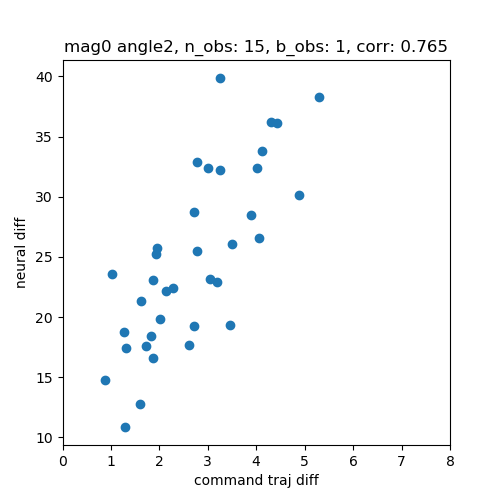

(0, 8)

In [69]:
# $[-5,5]

n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)

b_min_obs=1
sel_b = (df_nu.loc[:,'b_obs_0']>=b_min_obs) & (df_nu.loc[:,'b_obs_1']>=b_min_obs)


sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_n & sel_b & sel_command
sel_str = 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff_L2']
# n = df_nu.loc[sel,'n_diff_L1_avg'] 

u_ex = copy.copy(u)
n_ex = copy.copy(n)
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(sel_str + ', n_obs: ' + str(n_min_obs) + ', b_obs: '+ str(b_min_obs) + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


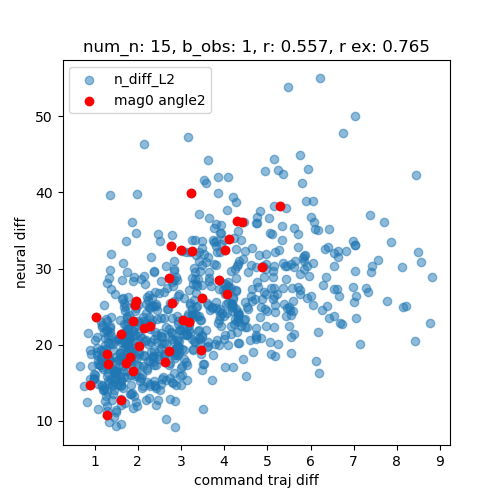

In [70]:
# $[-5,5]
n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)

b_min_obs=1
sel_b = (df_nu.loc[:,'b_obs_0']>=b_min_obs) & (df_nu.loc[:,'b_obs_1']>=b_min_obs)

sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
c_str = 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_n & sel_b
sel_ex = sel & sel_command
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff_L2']

u_ex = df_nu.loc[sel_ex,'u_diff']
n_ex = df_nu.loc[sel_ex,'n_diff_L2']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

nu_ex_corr_mat = np.corrcoef(u_ex,n_ex)
nu_ex_corr = nu_ex_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n,alpha=0.5)
plt.scatter(u_ex,n_ex,label=sel_str, color='r')
# plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
title_str = 'num_n: ' + str(n_min_obs) + ', b_obs: '+ str(b_min_obs) + ', r: ' \
+ str(round(nu_corr,3)) + ', r ex: ' + str(round(nu_ex_corr,3))
plt.title(title_str)
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])
plt.legend()

<IPython.core.display.Javascript object>


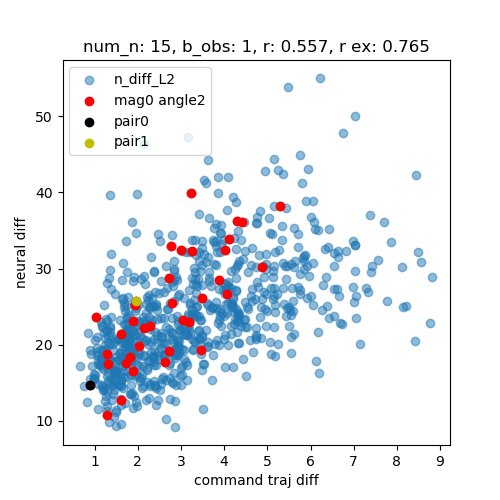

In [94]:
#highlight two pairs of movements
c_sel = (0,2)

m_0 = (2, 1.1)
m_1 = (2, 0)
m_2 = (3, 0)

#m_1 vs m_0
sel_p0 = \
    (df_nu['target_0'] == 2)&(df_nu['task_0'] == 0)\
    &(df_nu['target_1'] == 2)&(df_nu['task_1'] == 1.1)\
    &(df_nu['u_v_mag_bin']==c_sel[0])\
    &(df_nu['u_v_angle_bin']==c_sel[1])\

#m_2 vs m_0
sel_p1 = (df_nu['target_0'] == 2)&(df_nu['task_0'] == 1.1)\
    &(df_nu['target_1'] == 3)&(df_nu['task_1'] == 0)\
    &(df_nu['u_v_mag_bin']==c_sel[0])\
    &(df_nu['u_v_angle_bin']==c_sel[1])\

ex_df = df_nu.loc[sel,['n_diff_L2', 'u_diff', 'target_0', 'task_0', 'target_1', 'task_1']]
n_p0 = df_nu.loc[sel_p0,['n_diff_L2']]
u_p0 = df_nu.loc[sel_p0,['u_diff']]

n_p1 = df_nu.loc[sel_p1,['n_diff_L2']]
u_p1 = df_nu.loc[sel_p1,['u_diff']]

         
         
         
 # $[-5,5]
n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)

b_min_obs=1
sel_b = (df_nu.loc[:,'b_obs_0']>=b_min_obs) & (df_nu.loc[:,'b_obs_1']>=b_min_obs)

sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
c_str = 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_n & sel_b
sel_ex = sel & sel_command
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff_L2']

u_ex = df_nu.loc[sel_ex,'u_diff']
n_ex = df_nu.loc[sel_ex,'n_diff_L2']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

nu_ex_corr_mat = np.corrcoef(u_ex,n_ex)
nu_ex_corr = nu_ex_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n,alpha=0.5)
plt.scatter(u_ex,n_ex,label=sel_str, color='r')
plt.scatter(u_p0,n_p0, label='pair0',color='k')
plt.scatter(u_p1,n_p1, label='pair1',color='y')

# plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
title_str = 'num_n: ' + str(n_min_obs) + ', b_obs: '+ str(b_min_obs) + ', r: ' \
+ str(round(nu_corr,3)) + ', r ex: ' + str(round(nu_ex_corr,3))
plt.title(title_str)
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])
plt.legend()

In [142]:
df_ex_p

,u_min,u_max,n_min,n_max,target_0,task_0,target_min,task_min,target_max,task_max
0,1.731406,5.291193,17.605042,38.260438,0,1.1,1.0,0.0,5.0,1.2
0,1.279385,4.305745,18.721439,36.226414,1,0.0,1.0,1.1,5.0,1.2
0,1.279385,4.873836,18.721439,30.144470,1,1.1,1.0,0.0,5.0,1.2
0,0.880390,4.021451,14.741864,32.381769,2,0.0,2.0,1.1,5.0,1.2
0,0.880390,4.053540,14.741864,26.607127,2,1.1,2.0,0.0,5.0,1.2
0,1.028817,4.422625,23.601868,36.159273,3,0.0,3.0,1.1,0.0,1.1
0,1.028817,3.889081,23.601868,28.510086,3,1.1,3.0,0.0,0.0,1.1
0,1.618007,4.116855,21.355620,33.826205,4,1.1,5.0,1.2,0.0,1.1
0,1.618007,5.291193,21.355620,38.260438,5,1.2,4.0,1.1,0.0,1.1


<IPython.core.display.Javascript object>


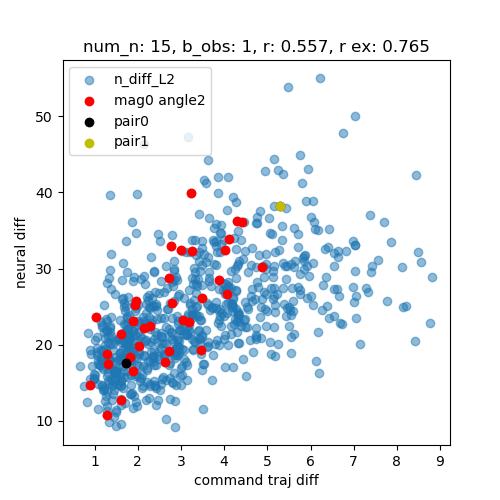

In [143]:
#The best example looks like: 
#target_0, task_0
#df_ex_p






#highlight two pairs of movements
c_sel = (0,2)

m_0 = (0, 1.1)
m_1 = (1, 0)
m_2 = (5, 1.2)

#m_1 vs m_0
sel_p0 = \
    (df_nu['target_0'] == 0)&(df_nu['task_0'] == 1.1)\
    &(df_nu['target_1'] == 1)&(df_nu['task_1'] == 0)\
    &(df_nu['u_v_mag_bin']==c_sel[0])\
    &(df_nu['u_v_angle_bin']==c_sel[1])\

#m_2 vs m_0
sel_p1 = (df_nu['target_0'] == 0)&(df_nu['task_0'] == 1.1)\
    &(df_nu['target_1'] == 5)&(df_nu['task_1'] == 1.2)\
    &(df_nu['u_v_mag_bin']==c_sel[0])\
    &(df_nu['u_v_angle_bin']==c_sel[1])\

ex_df = df_nu.loc[sel,['n_diff_L2', 'u_diff', 'target_0', 'task_0', 'target_1', 'task_1']]
n_p0 = df_nu.loc[sel_p0,['n_diff_L2']]
u_p0 = df_nu.loc[sel_p0,['u_diff']]

n_p1 = df_nu.loc[sel_p1,['n_diff_L2']]
u_p1 = df_nu.loc[sel_p1,['u_diff']]

         
         
         
 # $[-5,5]
n_min_obs=15
sel_n = (df_nu.loc[:,'obs_0']>=n_min_obs) & (df_nu.loc[:,'obs_1']>=n_min_obs)

b_min_obs=1
sel_b = (df_nu.loc[:,'b_obs_0']>=b_min_obs) & (df_nu.loc[:,'b_obs_1']>=b_min_obs)

sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
c_str = 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_n & sel_b
sel_ex = sel & sel_command
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff_L2']

u_ex = df_nu.loc[sel_ex,'u_diff']
n_ex = df_nu.loc[sel_ex,'n_diff_L2']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

nu_ex_corr_mat = np.corrcoef(u_ex,n_ex)
nu_ex_corr = nu_ex_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n,alpha=0.5)
plt.scatter(u_ex,n_ex,label=sel_str, color='r')
plt.scatter(u_p0,n_p0, label='pair0',color='k')
plt.scatter(u_p1,n_p1, label='pair1',color='y')

# plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
title_str = 'num_n: ' + str(n_min_obs) + ', b_obs: '+ str(b_min_obs) + ', r: ' \
+ str(round(nu_corr,3)) + ', r ex: ' + str(round(nu_ex_corr,3))
plt.title(title_str)
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])
plt.legend()

In [77]:
list(df_nu.columns)

['n_diff_L2',
 'n_diff_L1_avg',
 'n_diff_L1_valid',
 'n_frac_diff_L1_validz_n_diff_L2',
 'z_n_diff_L1_avg',
 'z_n_diff_L1_valid',
 'z_n_frac_diff_L1_validu_diff',
 'obs_0',
 'obs_1',
 'b_obs_0',
 'b_obs_1command_idx',
 'movement_idx_0',
 'movement_idx_1',
 'u_v_mag_bin',
 'u_v_angle_bin',
 'target',
 'task_rot',
 'n_frac_diff_L1_valid',
 'z_n_diff_L2',
 'z_n_frac_diff_L1_valid',
 'u_diff',
 'b_obs_1',
 'command_idx',
 'task_0',
 'task_1',
 'target_0',
 'target_1']

In [79]:
sel_p0 = (df_nu['target_0'] == 2)&(df_nu['task_0'] == 0)\
    &(df_nu['target_1'] == 2)&(df_nu['task_1'] == 1.1)\
    &(df_nu['u_v_mag_bin']==0)\
    &(df_nu['u_v_angle_bin']==2)\
df_nu.loc[sel_p0, ['n_diff_L2', 'u_diff', 'target_0', 'task_0', 'target_1', 'task_1']]

,n_diff_L2,u_diff,target_0,task_0,target_1,task_1
112,14.741864,0.88039,2.0,0.0,2.0,1.1


In [82]:
sel_p1 = (df_nu['target_0'] == 2)&(df_nu['task_0'] == 1.1)\
    &(df_nu['target_1'] == 3)&(df_nu['task_1'] == 0)\
    &(df_nu['u_v_mag_bin']==0)\
    &(df_nu['u_v_angle_bin']==2)\

df_nu.loc[sel_p1, ['n_diff_L2', 'u_diff', 'target_0', 'task_0', 'target_1', 'task_1']]

,n_diff_L2,u_diff,target_0,task_0,target_1,task_1
117,25.772255,1.957188,2.0,1.1,3.0,0.0


### See the command-locked position trajectories

In [122]:
#get the movements in the matched_pairs
#calculate the position locked psth, and lag0 centered position locked psth

In [41]:
#get the movements in the command's matched_pairs
c = (0,2)
m_analyze = []
for mp in cmpair_d[c,'matched_pairs']:
    for m in mp: 
        if m not in m_analyze:
            m_analyze.append(m)
m_analyze

[(0, 1.1),
 (1, 0),
 (1, 1.1),
 (2, 0),
 (2, 1.1),
 (3, 0),
 (3, 1.1),
 (4, 1.1),
 (5, 1.2)]

In [42]:
#loop movements, get the position psth, lag0 centered psth
#use all the observations of the command
b_bin_buffer = 5
sel_b = (df['bin']>=b_bin_buffer)&(df['bin_end']>=b_bin_buffer)


psth_var = ['kin_px', 'kin_py']
win = [-5,5]
psth_list = []
psthc_list = []
for m in m_analyze: 
#     idx = np.where(cm_dic[c,m,'sel'])[0]
    
    idx_sel = cm_dic[c,m,'sel']
    idx_sel_a = idx_sel & sel_b
    idx_a = np.where(idx_sel_a)[0]    
    print(m, idx_a)
    
    da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx_a, win, psth_var)
    #center at lag0:
    psthc = psth-psth.loc[:,0]
    psth_list.append(psth)
    psthc_list.append(psthc)    

((0, 1.1), array([2378, 2483, 2484, 2531, 2568, 2603, 2641, 2644, 2756, 2787, 2830,
       6882, 6954, 7010, 7039, 7088, 7128, 7174, 7206, 7214, 7287, 7322],
      dtype=int64))
((1, 0), array([300, 328, 329, 342, 348, 356, 358, 362, 366, 416, 440, 442, 450,
       480, 513, 521, 526, 545, 581, 617], dtype=int64))
((1, 1.1), array([2845, 2865, 2867, 2875, 2934, 2948, 2980, 2985, 2991, 3009, 3022,
       3066, 3071, 3072, 3073, 3108, 3112, 3154, 3184, 3198, 3266, 3273,
       3281, 3312, 3317, 7370, 7419, 7448, 7488, 7502, 7550, 7555, 7563,
       7568, 7657, 7667, 7677, 7711, 7713, 7792, 7817, 7864, 7878, 7948],
      dtype=int64))
((2, 0), array([640, 643, 644, 645, 648, 654, 658, 663, 685, 722, 753, 755, 756,
       768, 829, 831, 835, 845, 870, 878, 887, 915, 948], dtype=int64))
((2, 1.1), array([3387, 3399, 3403, 3404, 3411, 3443, 3473, 3493, 3518, 3543, 3545,
       3547, 3571, 3573, 3604, 3644, 3673, 3686, 3693, 3694, 3712, 3767,
       3796, 3809, 3838, 3844, 3845, 3858, 3859, 8

<IPython.core.display.Javascript object>


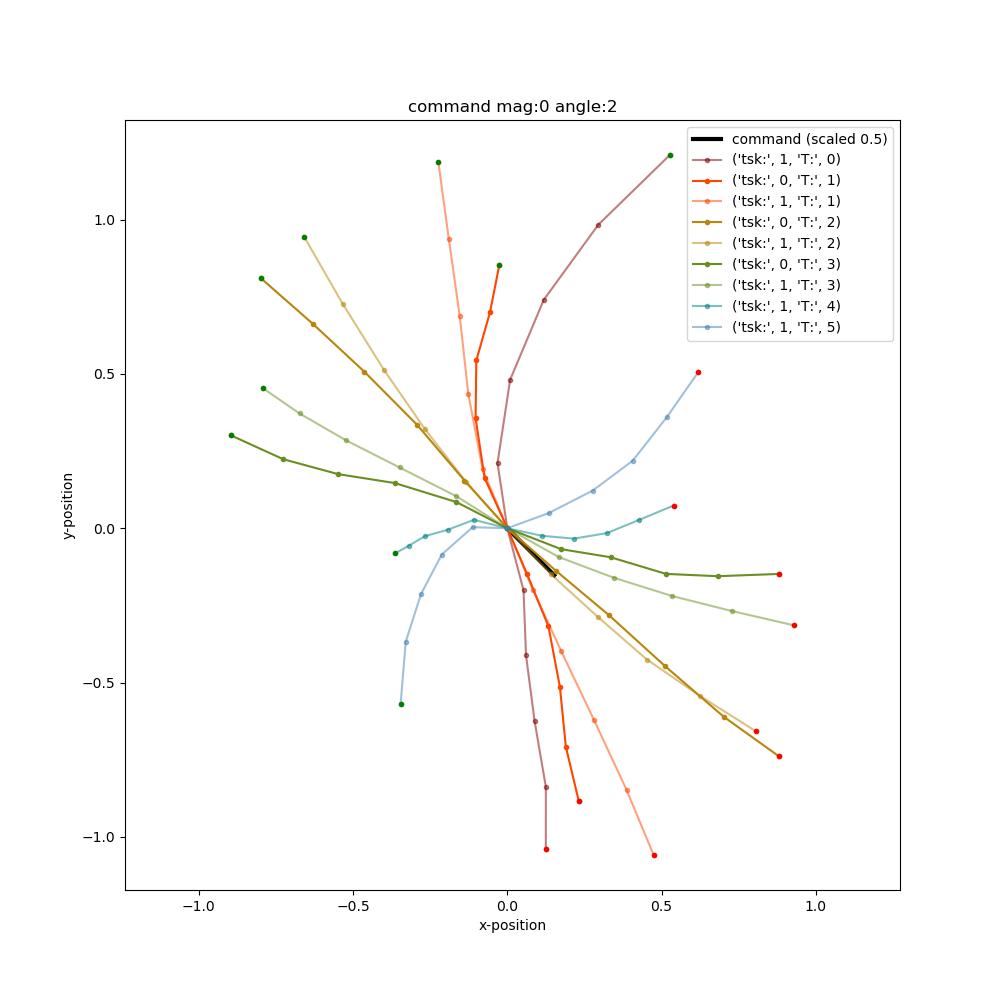

Text(0.5,1,'command mag:0 angle:2')

In [43]:
#PLOT the position PSTH

mag_bin = c[0]
angle_bin = c[1]
sc = 0.5

pm = mag_bin_c[mag_bin]
pa = angle_bin_c[angle_bin]
x_bin = pm*np.cos(pa)*sc
y_bin = pm*np.sin(pa)*sc

task_alpha = [1, 0.5]
plt.figure(figsize=(10,10))
plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
for i,psthc in enumerate(psthc_list):
    m = m_analyze[i]
    task = int(round(m[1]))
    target = int(m[0])
    plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
    plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
    plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  
    

plt.axis('equal')
plt.legend()
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.title('command mag:'+str(mag_bin) + ' angle:' + str(angle_bin))

In [27]:
#Calculate u psth
psth_var = ['u_vx', 'u_vy']
win = [-5,5]
psth_list = []
psth_sem_list = []
for m in m_analyze: 
    idx = np.where(cm_dic[c,m,'sel'])[0]
    da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx, win, psth_var)
    #center at lag0:
    psth_list.append(psth)
    psth_sem_list.append(psth_sem)

<IPython.core.display.Javascript object>


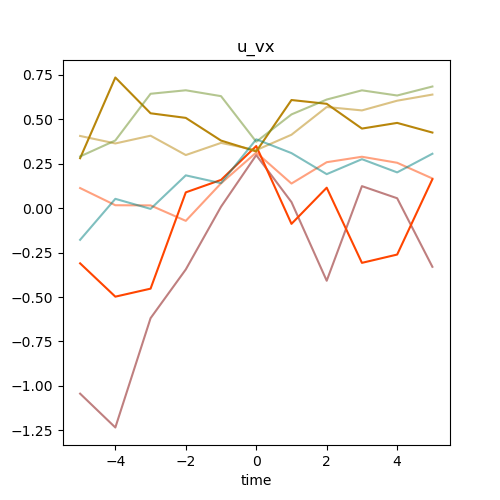

<IPython.core.display.Javascript object>


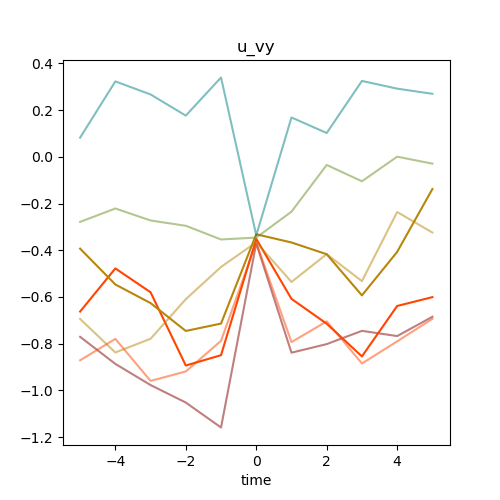

In [28]:
#Plot the u psth: 
mag_bin = c[0]
angle_bin = c[1]
sc = 0.5
t = np.arange(win[0],win[1]+1)
plot_sem = False

for v in psth_var:
    plt.figure(figsize=(5,5))
    plt.title(v)
    plt.xlabel('time')
    for i,m in enumerate(m_analyze):
        y = psth_list[i].loc[v,:]
        y_sem = psth_sem_list[i].loc[v,:]
        
        task = int(round(m[1]))
        target = int(m[0]) 
        
        plt.plot(t,y, color=target_color[target], alpha=task_alpha[task], label=('tsk:',task,'T:',target))
        if plot_sem:
            plt.fill_between(t,y-y_sem,y+y_sem,alpha=task_alpha[task]*0.5, color=target_color[target])
#     plt.legend()
    


# pm = mag_bin_c[mag_bin]
# pa = angle_bin_c[angle_bin]
# x_bin = pm*np.cos(pa)*sc
# y_bin = pm*np.sin(pa)*sc

# task_alpha = [1, 0.5]
# plt.figure(figsize=(7,7))
# plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
# for i,psthc in enumerate(psthc_list):
#     m = m_analyze[i]
#     task = int(round(m[1]))
#     target = int(m[0])
#     plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
#     plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
#     plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  
    

# plt.axis('equal')
# plt.legend()
# plt.xlabel('x-position')
# plt.ylabel('y-position')

### Check that if neural dynamics can explain diff corr to behavior

In [ ]:
#First fit dynamics on all data... 

In [29]:
sel_bin = df.loc[:,'bin']>=0
sel_bin_end = df.loc[:,'bin_end']>=1
sel = sel_bin&sel_bin_end
idx = np.where(sel)[0]
var = copy.copy(n_list)
da_t = bmi_b.df_idx2da(df, idx, var)
da_t = da_t.T

In [30]:
sel_bin = df.loc[:,'bin']>=1
sel_bin_end = df.loc[:,'bin_end']>=0
sel = sel_bin&sel_bin_end
idx = np.where(sel)[0]
var = copy.copy(n_list)
da_tp1 = bmi_b.df_idx2da(df, idx, var)
da_tp1=da_tp1.T

In [31]:
da_t.shape

(11583L, 44L)

In [32]:
da_t

<xarray.DataArray (observation: 11583, v: 44)>
array([[ 3.,  0.,  0., ...,  2.,  0.,  1.],
       [ 1.,  0.,  0., ...,  1.,  0.,  3.],
       [ 0.,  1.,  0., ...,  3.,  2.,  1.],
       ...,
       [ 0.,  0.,  0., ..., 13.,  1.,  1.],
       [ 0.,  0.,  0., ...,  7.,  3.,  2.],
       [ 3.,  0.,  0., ...,  6.,  0.,  0.]])
Coordinates:
  * observation  (observation) int64 10 11 12 13 14 ... 14713 14714 14715 14716
  * v            (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [33]:
da_tp1

<xarray.DataArray (observation: 11583, v: 44)>
array([[1., 0., 0., ..., 1., 0., 3.],
       [0., 1., 0., ..., 3., 2., 1.],
       [2., 0., 0., ..., 5., 0., 1.],
       ...,
       [0., 0., 0., ..., 7., 3., 2.],
       [3., 0., 0., ..., 6., 0., 0.],
       [1., 0., 1., ..., 1., 2., 2.]])
Coordinates:
  * observation  (observation) int64 11 12 13 14 15 ... 14714 14715 14716 14717
  * v            (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
#linear regression: num_samples X num_observations
reg = LinearRegression(fit_intercept=False).fit(da_t, da_tp1)
#Predict next step
reg.score(da_t,da_tp1)

0.22667870544107147

In [ ]:
#Now, we should do conditioning on command... 


### Condition on command and last neural activity pattern

In [36]:
#0) the data
#n_da 
#n_t_da
#n_tp1_da

var = copy.copy(n_list)

#n_da
sel_bin = df.loc[:,'bin']>=0
sel_bin_end = df.loc[:,'bin_end']>=0
sel = sel_bin&sel_bin_end
idx = np.where(sel)[0]
n_da = bmi_b.df_idx2da(df, idx, var)


In [37]:
n_da.shape

(44L, 11868L)

In [38]:
nc_list = ['nc_'+str(i) for i in range(num_neurons)]

In [132]:
#1) zero mean the data: 
n_da_mean = n_da.mean(axis=1)
nc_da = n_da - n_da_mean
# df.loc[:,'']

In [130]:
#2) make t and tp1 matrices (centered)
#n_t_da
sel_bin = df.loc[:,'bin']>=0
sel_bin_end = df.loc[:,'bin_end']>=1
sel = sel_bin&sel_bin_end
idx = np.where(sel)[0]
n_t_da = bmi_b.df_idx2da(df, idx, var)
nc_t_da = n_t_da-n_da_mean

#n_tp1_da
sel_bin = df.loc[:,'bin']>=1
sel_bin_end = df.loc[:,'bin_end']>=0
sel = sel_bin&sel_bin_end
idx = np.where(sel)[0]
n_tp1_da = bmi_b.df_idx2da(df, idx, var)
nc_tp1_da = n_tp1_da-n_da_mean
idx_tp1 = copy.copy(idx) # we need this for assignment later

In [124]:
n_t_da.shape

(44L, 11583L)

In [126]:
n_tp1_da.shape

(44L, 11583L)

In [131]:
#3) Fit dynamics matrix: 
#linear regression: num_samples X num_observations
reg = LinearRegression(fit_intercept=False).fit(nc_t_da.T, nc_tp1_da.T)
#Predict next step
VAF = reg.score(nc_t_da.T,nc_tp1_da.T)
A = reg.coef_
print(VAF)

# #confirm A is the right form: 
# test = np.dot(A,n_t_da)

# var_explained = np.trace(np.cov(test))
# var_total = np.trace(np.cov(n_t_da))

# frac_var_explained = var_explained/var_total
# print(frac_var_explained)

0.24653241212006552


<IPython.core.display.Javascript object>


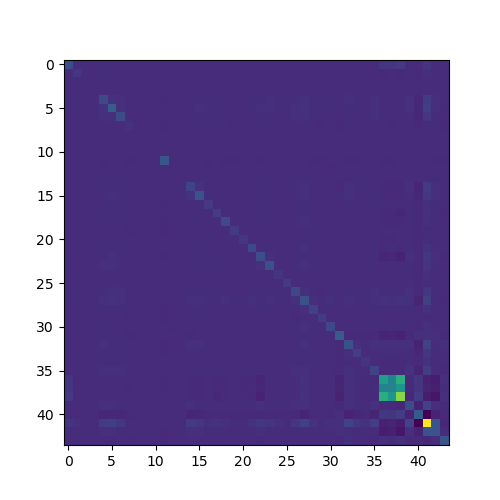

<IPython.core.display.Javascript object>


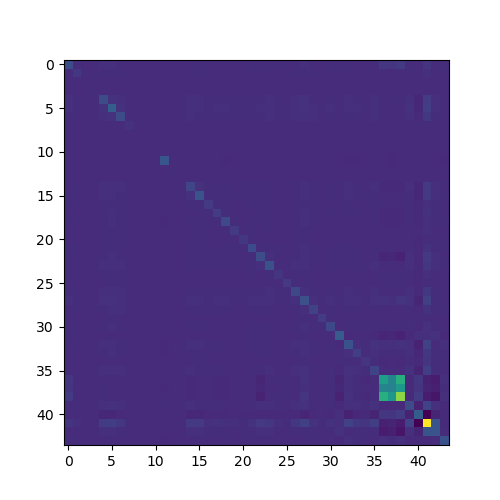

<IPython.core.display.Javascript object>


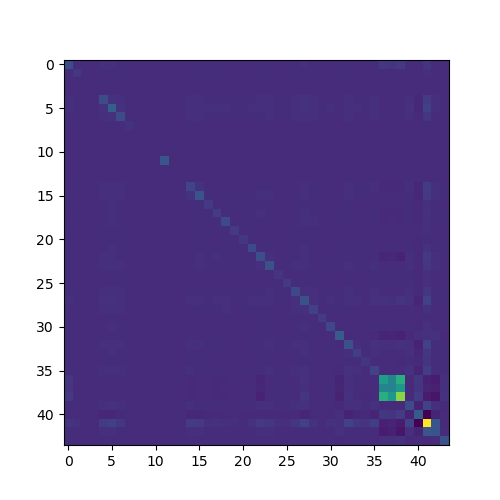

In [133]:
#4) Neural Covariance
Sn = np.cov(nc_da)
Sn_t = np.cov(nc_t_da)
Sn_tp1 = np.cov(nc_tp1_da)

plt.figure(figsize=(5,5))
plt.imshow(Sn)

plt.figure(figsize=(5,5))
plt.imshow(Sn_t)

plt.figure(figsize=(5,5))
plt.imshow(Sn_tp1)

In [43]:
#5) Decoder mapping to u_vx, u_vy
dd = bmi_util.decompose_decoder(decoder['F'], decoder['K'])
K = decoder['K'][dd['var_idxs']['v'],:]

# #confirm decoder:
# nt = df.loc[0,n_list]
# nt.shape
# print(np.dot(K, nt))
# print(df.loc[0,['u_vx', 'u_vy']])

F_hat close to F
K_hat close to K


In [134]:
#6) Define conditioning matrix
#use notation of fx|y
#X = n_tp1
#Y = n_t, Kn_tp1
#M = np.dot(S_XY, inv(S_Y))

use_cov_t = True
#Using the covariance of specific times doesn't make a difference

if use_cov_t: 
    S_XY = np.concatenate((np.dot(A,Sn_t), np.dot(Sn_tp1,K.T)), axis=1)

    TL = Sn_t
    TR = np.dot(Sn_t, np.dot(A.T, K.T))
    BR = np.dot(np.dot(K, Sn_tp1), K.T)
    BL = TR.T
    S_Y_top = np.concatenate((TL, TR),axis=1)
    S_Y_bot = np.concatenate((BL, BR),axis=1)
    S_Y = np.concatenate((S_Y_top, S_Y_bot),axis=0)

    M = np.dot(S_XY, np.linalg.inv(S_Y))
    
else:
    S_XY = np.concatenate((np.dot(A,Sn), np.dot(Sn,K.T)), axis=1)

    TL = Sn
    TR = np.dot(Sn, np.dot(A.T, K.T))
    BR = np.dot(np.dot(K, Sn), K.T)
    BL = TR.T
    S_Y_top = np.concatenate((TL, TR),axis=1)
    S_Y_bot = np.concatenate((BL, BR),axis=1)
    S_Y = np.concatenate((S_Y_top, S_Y_bot),axis=0)

    M = np.dot(S_XY, np.linalg.inv(S_Y))    
    

In [135]:
#7) Perform conditioning: 
#n_t_da #previous neural
Knc_tp1_da = np.dot(K, nc_tp1_da) #output
in_mat = np.concatenate((np.array(nc_t_da), np.array(Knc_tp1_da)),axis=0)
out_mat = np.dot(M, in_mat) #+ np.array(n_da_mean).reshape((-1,1))

cond_res = out_mat-np.array(nc_tp1_da)
reg_res = np.array(np.dot(A, nc_t_da))-np.array(nc_tp1_da)
print(np.trace(np.cov(cond_res)))
print(np.trace(np.cov(reg_res)))
#Yay!

46.00488386219822
55.1125302441253


In [136]:
#8) save back the predicted activity
n_tp1_hat = out_mat+np.array(n_da_mean).reshape((-1,1))
true_res = n_tp1_hat-np.array(n_tp1_da)
print(np.trace(np.cov(true_res)))
print(np.trace(np.cov(n_tp1_da)))

n_cond_list = ['n_cond_' + str(i) for i in range(num_neurons)]

df_cond = pd.DataFrame(index=df.index, columns=n_cond_list)
df_cond.loc[idx_tp1,:] = n_tp1_hat.T

#concat to df: 
# df = pd.concat([df, df_cond],axis=1)

In [207]:
#Confirm action remains
n_cond = np.array(df.loc[idx_tp1,n_cond_list]).T
u_cond = np.dot(K, n_cond)
u = np.array(df.loc[idx_tp1,['u_vx', 'u_vy']]).T

print(u_cond[:,10])
print(u[:,10])

[-0.2075238302020483 -0.43432743711727945]
[-0.20752383 -0.43432744]


### Inspect

In [163]:
df.loc[idx_tp1,n_list].shape

(11583, 44)

In [165]:
df.loc[idx_tp1,n_cond_list].shape

(11583, 44)

In [178]:
df.loc[idx_tp1,n_list]

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
11,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,0.0,3.0
12,0.0,1.0,0.0,1.0,1.0,2.0,3.0,2.0,0.0,0.0,...,0.0,2.0,1.0,1.0,1.0,3.0,0.0,3.0,2.0,1.0
13,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,1.0,1.0,3.0,5.0,0.0,1.0
14,1.0,0.0,0.0,0.0,4.0,5.0,1.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,1.0,1.0,1.0,6.0,0.0,0.0
15,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,2.0,0.0,11.0,3.0,2.0
16,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0
17,3.0,1.0,0.0,0.0,2.0,5.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0
18,1.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0
19,2.0,0.0,0.0,0.0,2.0,3.0,3.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,2.0,1.0,5.0,0.0,1.0
20,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,5.0,1.0,3.0


In [177]:
df.loc[idx_tp1,n_cond_list]

,n_cond_0,n_cond_1,n_cond_2,n_cond_3,n_cond_4,n_cond_5,n_cond_6,n_cond_7,n_cond_8,n_cond_9,...,n_cond_34,n_cond_35,n_cond_36,n_cond_37,n_cond_38,n_cond_39,n_cond_40,n_cond_41,n_cond_42,n_cond_43
11,1.04389,0.504845,0.0231359,0.0503433,0.915083,1.79771,1.1976,0.337876,0.0255074,0.0115084,...,0.67473,0.875464,1.99934,1.52338,2.63258,1.20028,1.93674,2.05105,0.139776,1.28723
12,1.21783,0.513724,0.057288,0.0571718,1.73754,2.31025,1.77504,0.18121,0.00930319,0.0224216,...,0.705032,1.75521,1.95519,1.54655,2.00688,2.40554,-0.349515,3.90243,0.516169,1.5704
13,1.15339,0.44983,0.0371749,0.0363344,1.26531,2.91281,1.39846,0.285905,-0.00101627,0.0302641,...,0.316611,1.20013,-0.0668863,0.0873719,-0.147818,1.26845,1.03522,4.12997,1.78518,1.42204
14,1.21275,0.473595,0.0391269,0.0609577,1.63101,2.39308,1.62292,0.226627,0.0328683,0.00624014,...,0.826706,1.69079,1.75802,1.36126,1.70356,2.3103,1.13644,5.93655,0.358654,1.07273
15,1.23573,0.593755,0.0340939,0.0473371,1.70236,2.9253,1.76411,0.261732,0.0170058,0.0230109,...,0.564258,1.74839,0.39713,0.344116,0.161947,1.97619,0.576597,6.80574,0.880215,0.937343
16,1.19977,0.574645,0.00483605,0.0266614,1.11139,2.29315,1.31122,0.387786,0.0243469,0.000866236,...,0.223574,0.871525,1.25037,0.993815,1.95849,0.875378,1.38278,6.60869,2.39921,1.1214
17,1.15975,0.54856,0.0277227,0.0537128,1.3606,2.46144,1.62599,0.215381,-0.00617592,0.00143406,...,0.418276,1.44431,-0.0991846,-0.0955294,-0.46135,1.68595,0.254922,4.50275,0.764797,0.996264
18,1.36465,0.613458,0.0309553,0.0407908,1.86618,3.00235,1.93869,0.283388,0.0118044,0.0117248,...,0.729871,1.76607,1.00462,0.68401,0.788991,2.47303,-0.48849,6.39495,0.747763,0.753414
19,1.13251,0.517889,0.0233837,0.0227631,1.31561,2.68303,1.45174,0.314241,0.0186468,0.00842977,...,0.529177,1.3571,0.642452,0.494164,0.821391,1.83791,0.766418,4.96772,0.786467,0.98706
20,1.1446,0.551101,0.0329107,0.0257743,1.57387,2.60778,1.57652,0.267577,0.014232,0.0100943,...,0.615117,1.5053,0.731039,0.570118,0.565944,2.22464,0.196957,5.73048,0.786232,0.872564


In [185]:

df_res = np.array(df.loc[idx_tp1,n_list]) - np.array(df.loc[idx_tp1,n_cond_list])
df_res = df_res.astype(float)
print(np.trace(np.cov(df_res.T)))




46.00488386219822
16005.565373887246


In [187]:
print(np.trace(np.cov(np.array(df.loc[idx_tp1,n_list]).astype(float).T)))

73.15056843572356


In [189]:
print(np.trace(np.cov(np.array(df.loc[idx_tp1,n_cond_list]).astype(float).T)))

27.14691818048731


In [173]:
df_res.min()

-10.598577869368736

In [174]:
df_res.max()

16.970855124195687

In [170]:
df_res.shape

(11583L, 44L)

In [171]:
#np.cov - each row is a variable, each column is an observation

### Use the conditioned/predicted activity to replicate the previous analysis

In [159]:
#USE MATCHED DATA
t_start = timeit.default_timer()
for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
        cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
            
        #--------------------------------------------------------------------------------
        #n_mean: 
        n_mean_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da = bmi_b.df_idx2da(df, idx, n_list)
            n_mean_list.append(da.mean(dim='observation'))
        cmpair_d[c,mp[0],mp[1],'n_mean'] = n_mean_list
        cmpair_d[c,mp[0],mp[1],'n_diff'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1])
        
        #--------------------------------------------------------------------------------
        #n_cond_mean: 
        n_cond_mean_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da = bmi_b.df_idx2da(df, idx, n_cond_list)
            n_cond_mean_list.append(da.mean(dim='observation'))
        cmpair_d[c,mp[0],mp[1],'n_cond_mean'] = n_cond_mean_list
        cmpair_d[c,mp[0],mp[1],'n_cond_diff'] = np.linalg.norm(n_cond_mean_list[0]-n_cond_mean_list[1])        


        #--------------------------------------------------------------------------------
        #u_psth:
        win = [-5,5]
        psth_var = ['u_vx', 'u_vy']
        psth_list = []
        psth_sem_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx, win, psth_var)
            psth_list.append(psth)
            psth_sem_list.append(psth_sem)
        #ASSIGN:
        cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
        cmpair_d[c,mp[0],mp[1],'u_psth'] = psth_list
        cmpair_d[c,mp[0],mp[1],'u_diff'] = np.linalg.norm(psth_list[0]-psth_list[1])
        cmpair_d[c,mp[0],mp[1],'u_psth_sem'] = psth_sem_list

t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)


(0, 0)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 1)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 2)
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 3)
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (4, 1.2))
((2, 1.1), (5, 1.2))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((4, 1.1)

In [160]:
#-------------------------------------------------------------------------------------------------------------------
#USING ONLY MATCHED DATA:
t_start = timeit.default_timer()

# TODO: 
u_win = [-5,5] 
u_win_t = np.arange(u_win[0], u_win[1]+1)
# u_win_t = 0
df_list = []
df_columns = ['n_diff', 'n_cond_diff', 'u_diff',\
              'obs_0', 'obs_1',\
              'command_idx', 'movement_idx_0', 'movement_idx_1',\
              'u_v_mag_bin','u_v_angle_bin',\
              'target', 'task_rot']

for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
            
        df_i = pd.DataFrame(np.zeros(len(df_columns)).reshape(1,-1), columns=df_columns)


        df_i.loc[0,'n_diff'] = cmpair_d[c,mp[0],mp[1],'n_diff']
        df_i.loc[0,'n_cond_diff'] = cmpair_d[c,mp[0],mp[1],'n_cond_diff']
        
        u0 = cmpair_d[c,mp[0],mp[1],'u_psth'][0].loc[:,u_win_t]
        u1 = cmpair_d[c,mp[0],mp[1],'u_psth'][1].loc[:,u_win_t]

        df_i.loc[0,'u_diff'] = \
            np.linalg.norm(u0-u1)

        df_i.loc[0,'obs_0'] = obs0
        df_i.loc[0,'obs_1'] = obs1

        df_i.loc[0,'command_idx'] = c2idx[c]
        df_i.loc[0,'movement_idx_0'] = m2idx[mp[0]]
        df_i.loc[0,'movement_idx_1'] = m2idx[mp[1]]
        
        df_i.loc[0,'task_0'] = mp[0][1]
        df_i.loc[0,'task_1'] = mp[1][1]

        df_i.loc[0,'u_v_mag_bin'] = c[0]
        df_i.loc[0,'u_v_angle_bin'] = c[1]

        df_list.append(df_i)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
df_nu = pd.concat(df_list,ignore_index=True)

(0, 0)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 1)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 2)
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 3)
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (4, 1.2))
((2, 1.1), (5, 1.2))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((4, 1.1)

<IPython.core.display.Javascript object>


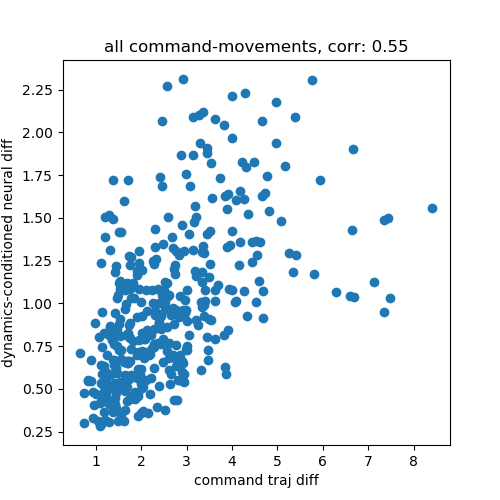

Text(0,0.5,'dynamics-conditioned neural diff')

In [200]:
# $[-5,5]
sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_obs # & sel_command
#sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
sel_str = 'all command-movements'
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_cond_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('dynamics-conditioned neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


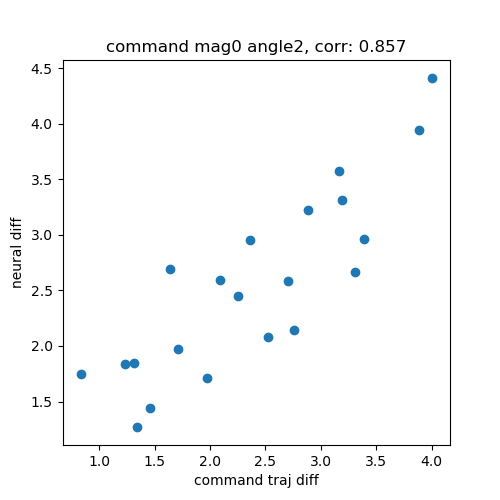

Text(0,0.5,'neural diff')

In [193]:
# $[-5,5]
sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_obs & sel_command
sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


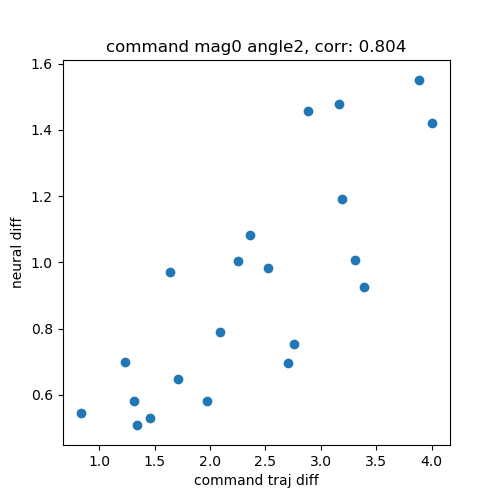

Text(0,0.5,'neural diff')

In [192]:
# $[-5,5]
sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_obs & sel_command
sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_cond_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


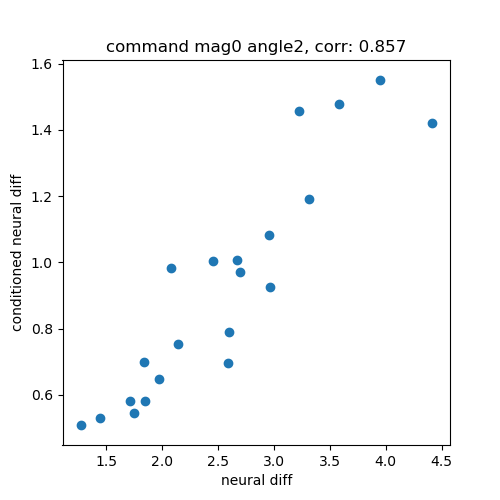

Text(0,0.5,'conditioned neural diff')

In [198]:
n = df_nu.loc[sel,'n_diff']
n_cond = df_nu.loc[sel,'n_cond_diff']

corr_mat = np.corrcoef(n,n_cond)
corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.title(sel_str + ', corr: ' + str(round(corr,3)))
plt.scatter(n,n_cond)
plt.xlabel('neural diff')
plt.ylabel('conditioned neural diff')

### CONTROL ANALYSIS: USE ALL DATA, NOT JUST MATCHED DATA

### Calculate differences

In [ ]:
#USE ALL DATA, including unmatched
t_start = timeit.default_timer()
min_obs = 15 #15
for c in c_list:
    for i,m0 in enumerate(cm_dic[c]):
        for j,m1 in enumerate(cm_dic[c]):
            if j>i:
                mp = (m0,m1)
                print(c, mp)
                idx0 = np.where(cm_dic[c,mp[0],'sel'])[0]
                idx1 = np.where(cm_dic[c,mp[1],'sel'])[0]
                idx_list = [idx0, idx1]
        #         obs0 = len(idx0)
        #         obs1 = len(idx1)
        # #         obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        # #         obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
        #         cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
        #         if sum(cmpair_d[c,mp[0],mp[1],'num_kept']>min_obs) ==2:
        
                #--------------------------------------------------------------------------------
                #n_mean: 
                n_mean_list = []
                for idx in idx_list: #cmpair_d[c,mp[0],mp[1],'kept_list']:
                    da = bmi_b.df_idx2da(df, idx, n_list)
                    n_mean_list.append(da.mean(dim='observation'))
                cmpair_d[c,mp[0],mp[1],'n_mean'] = n_mean_list
                cmpair_d[c,mp[0],mp[1],'n_diff'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1])

                #--------------------------------------------------------------------------------
                #u_psth:
                win = [-5,5]
                psth_var = ['u_vx', 'u_vy']
                psth_list = []
                psth_sem_list = []
                for idx in idx_list: #cmpair_d[c,mp[0],mp[1],'kept_list']:
                    da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx, win, psth_var)
                    psth_list.append(psth)
                    psth_sem_list.append(psth_sem)
                #ASSIGN:
                cmpair_d[c,mp[0],mp[1],'u_psth'] = psth_list
                cmpair_d[c,mp[0],mp[1],'u_diff'] = np.linalg.norm(psth_list[0]-psth_list[1])
                cmpair_d[c,mp[0],mp[1],'u_psth_sem'] = psth_sem_list

t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

### Make a results df

In [ ]:
#USING ALL DATA:
t_start = timeit.default_timer()
min_obs = 15

# TODO: 
u_win = [-5,5]
u_win_t = np.arange(u_win[0], u_win[1]+1)
df_list = []
df_columns = ['n_diff', 'u_diff',\
              'obs_0', 'obs_1',\
              'command_idx', 'movement_idx_0', 'movement_idx_1',\
              'u_v_mag_bin','u_v_angle_bin',\
              'target', 'task_rot']

for c in c_list:
    print(c)
    for i,m0 in enumerate(cm_dic[c]):
        for j,m1 in enumerate(cm_dic[c]):
            if j>i:
                mp = (m0,m1)
                idx0 = np.where(cm_dic[c,mp[0],'sel'])[0]
                idx1 = np.where(cm_dic[c,mp[1],'sel'])[0]
                idx_list = [idx0, idx1]
                obs0 = len(idx0)
                obs1 = len(idx1)

                df_i = pd.DataFrame(np.zeros(len(df_columns)).reshape(1,-1), columns=df_columns)

                df_i.loc[0,'n_diff'] = cmpair_d[c,mp[0],mp[1],'n_diff']
    #             df_i.loc[0,'u_diff'] = cmpair_d[c,mp[0],mp[1],'u_diff']

                u0 = cmpair_d[c,mp[0],mp[1],'u_psth'][0].loc[:,u_win_t]
                u1 = cmpair_d[c,mp[0],mp[1],'u_psth'][1].loc[:,u_win_t]
                df_i.loc[0,'u_diff'] = \
                    np.linalg.norm(u0-u1)
    #                 cmpair_d[c,mp[0],mp[1],'u_diff']

                df_i.loc[0,'obs_0'] = obs0
                df_i.loc[0,'obs_1'] = obs1

                df_i.loc[0,'command_idx'] = c2idx[c]
                df_i.loc[0,'movement_idx_0'] = m2idx[mp[0]]
                df_i.loc[0,'movement_idx_1'] = m2idx[mp[1]]

                df_i.loc[0,'u_v_mag_bin'] = c[0]
                df_i.loc[0,'u_v_angle_bin'] = c[1]       

                df_list.append(df_i)
            
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
df_nu = pd.concat(df_list,ignore_index=True)

### Plot Results

In [ ]:
# $[-1,1]
sel = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
u = df_nu.loc[:,'u_diff']
n = df_nu.loc[:,'n_diff']
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title('corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')